In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
medium_data = pd.read_csv('medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


In [4]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [5]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [6]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])  #Fits the tokenizer on the titles, creating a word index.
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [7]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]  #Converts each title to a sequence of integers.
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)  #Creates n-gram sequences from each title and appends them to input_sequences.

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [8]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))  # Pads the sequences to ensure they are all the same length.
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68])

In [9]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [10]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


In [11]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150))) #Adds a bidirectional LSTM layer with 150 units.
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=20, verbose=1)
#print model.summary()
print(model)

C:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 154s 98ms/step - accuracy: 0.0988 - loss: 7.0469
Epoch 2/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 154s 101ms/step - accuracy: 0.1737 - loss: 5.7325
Epoch 3/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 146s 96ms/step - accuracy: 0.2047 - loss: 5.1155
Epoch 4/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 146s 96ms/step - accuracy: 0.2264 - loss: 4.6974
Epoch 5/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 146s 96ms/step - accuracy: 0.2609 - loss: 4.2941
Epoch 6/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.3136 - loss: 3.5836
Epoch 7/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.3476 - loss: 3.2933
Epoch 8/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.3701 - loss: 3.1015
Epoch 9/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.3885 - loss: 2.9505
Epoch 10/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 149s 98ms/step - accuracy: 0.4063 - loss: 2.8413
Epoch 11/20
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 148s 98ms/step - accuracy: 0.4163 - loss: 2.7

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

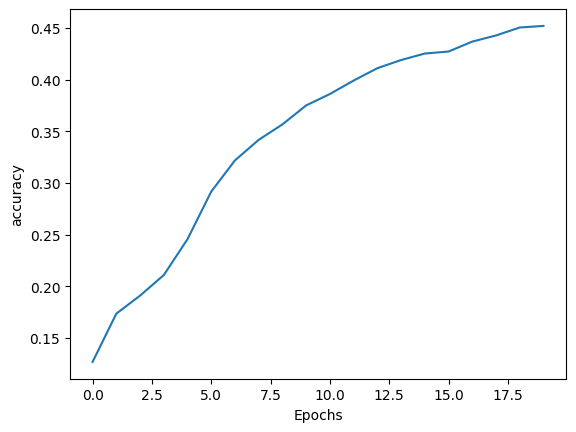

In [13]:
plot_graphs(history, 'accuracy')

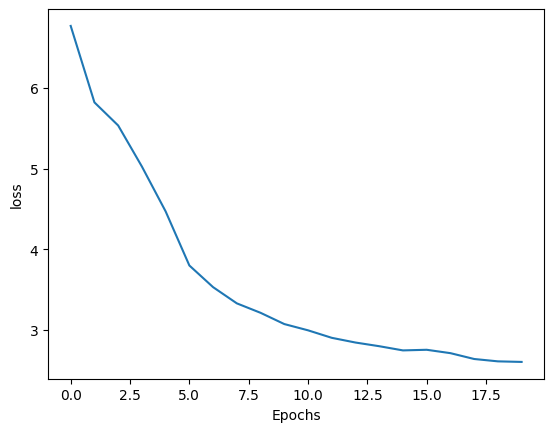

In [14]:
plot_graphs(history, 'loss')

In [19]:
seed_text = "hello"
next_words = 20

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)


hello of automation robotics finance using the current year… is leaving the game of thrones chatbot and nodejs attacks events —
